In [1]:
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F

# 0. Check cuda availability
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

# 1. Load the data from local file called 'names.txt'
with open('names.txt', 'r') as f:
    names = [line.strip() for line in f]
len(names), names[:5]

# 2. encode the char into a list of integers
symbols = sorted(list(set(''.join(names))))
char_to_int = {s:i+1 for i,s in enumerate(symbols)}
int_to_char = {i+1:s for i,s in enumerate(symbols)}
char_to_int['.'] = 0
int_to_char[0] = '.'
# char_to_int, int_to_char

In [2]:
# hyperparameters
block_size = 3
embedding_size = 2
hidden_size = 200
minibatch_size = 32

In [3]:
# 3. generate mapping from previous characters to next character
def build_dataset(names_set):
    input_char, output_char = [],[]
    for word in names_set[:]:
        input_word ='.'*block_size+word
        output_word = word + '.'
        for i in range(len(output_word)):
            input_char.append(list(input_word[i:i+block_size])) 
            output_char.append(output_word[i]) 
            
    # encode mapping into integers
    for i in range(len(input_char)):
        input_char[i] = [char_to_int[s] for s in input_char[i]]
        output_char[i] = char_to_int[output_char[i]]
    X = torch.tensor(input_char, device=device)
    Y = torch.tensor(output_char, device=device)
    return X, Y


# split dataset into train, validation, and testing
import random
random.shuffle(names)
train_size = int(len(names)*0.7)
val_size = int(len(names)*0.2)
Inputs_train, Labels_train = build_dataset( names[:train_size])
Inputs_val, Labels_val = build_dataset( names[train_size:train_size+val_size])
Inputs_test, Labels_test = build_dataset( names[train_size+val_size:])
Inputs_train.shape, Inputs_val.shape, Inputs_test.shape, Labels_train.shape, Labels_val.shape, Labels_test.shape

(torch.Size([159553, 3]),
 torch.Size([45669, 3]),
 torch.Size([22924, 3]),
 torch.Size([159553]),
 torch.Size([45669]),
 torch.Size([22924]))

In [4]:
# Initialize the parameters

# embedding layer
E = torch.rand((len(char_to_int), embedding_size), device=device, requires_grad=True)

# Tanh Hidden layer
W_hidden = torch.rand((embedding_size*block_size, hidden_size), device=device, requires_grad=True)
b_hidden = torch.rand(hidden_size, device=device, requires_grad=True)

# softmax output layer
W_out = torch.rand((hidden_size, len(char_to_int)), device=device, requires_grad=True)
b_out = torch.rand( len(char_to_int), device=device, requires_grad=True)

params = [E, W_hidden, b_hidden, W_out, b_out]

E.shape,W_hidden.shape, b_hidden.shape, W_out.shape, b_out.shape,sum([p.numel() for p in params])

(torch.Size([27, 2]),
 torch.Size([6, 200]),
 torch.Size([200]),
 torch.Size([200, 27]),
 torch.Size([27]),
 6881)

In [6]:
max_steps = 200000
loss_records = []
for i in range(max_steps):
    # construct minibatch
    index_this_batch = torch.randint(0, len(Inputs_train), (minibatch_size,))
    
    # forward pass
    embed = E[Inputs_train[index_this_batch]]
    hid = torch.tanh(embed.view(-1, embedding_size*block_size) @ W_hidden + b_hidden)
    log_counts = hid @ W_out + b_out
    loss = F.cross_entropy(log_counts, Labels_train[index_this_batch])
    if (i % 10000 == 0):
        print(str(i)+"/200000. loss: "+str(loss.item()))
    
    # backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # gradient descent
    learning_rate = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -1 * learning_rate * p.grad
    
    loss_records.append(loss.item())

0/200000. loss: 9.98569393157959
10000/200000. loss: 2.5355710983276367
20000/200000. loss: 2.2781083583831787
30000/200000. loss: 2.3111369609832764
40000/200000. loss: 2.1907906532287598
50000/200000. loss: 2.6794235706329346
60000/200000. loss: 2.2452354431152344
70000/200000. loss: 2.3585660457611084
80000/200000. loss: 2.3152360916137695
90000/200000. loss: 2.4816954135894775
100000/200000. loss: 1.885406494140625
110000/200000. loss: 2.150707483291626
120000/200000. loss: 2.097095012664795
130000/200000. loss: 2.155271530151367
140000/200000. loss: 2.466269016265869
150000/200000. loss: 2.4650912284851074
160000/200000. loss: 2.2013261318206787
170000/200000. loss: 2.1783454418182373
180000/200000. loss: 2.5240046977996826
190000/200000. loss: 2.2737395763397217


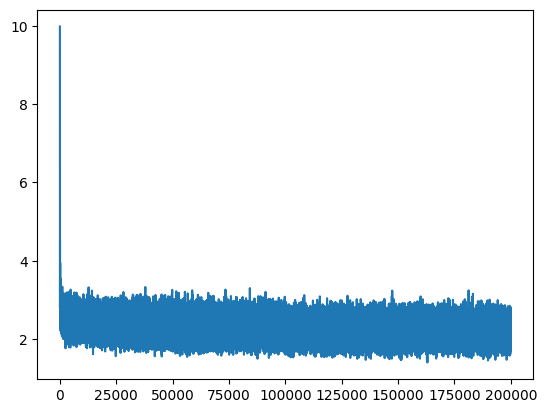

In [8]:
plt.plot(loss_records, label='loss')

In [10]:
@torch.no_grad()
def eval_loss(split):
    x,y = {
        "train": (Inputs_train, Labels_train),
        "val": (Inputs_val, Labels_val),
        "test": (Inputs_test, Labels_test)
    }[split]

    embed = E[x]
    hid = torch.tanh(embed.view(-1, embedding_size*block_size) @ W_hidden + b_hidden)
    log_counts = hid @ W_out + b_out
    loss = F.cross_entropy(log_counts, y)
    print(split, loss.item())

eval_loss("train")
eval_loss("val")

train 2.195824146270752
val 2.2201383113861084


In [ ]:
input = torch.randn(1000, 10)
weights = torch.randn(10, 200)

output = input @ weights
print(input.mean(), input.std())
print(output.mean(), output.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(input.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(output.view(-1).tolist(), 50, density=True)
